# Data Collection From Net Unicorn Into snl-server-5

## Import Dependencies

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import time
import pandas as pd
import subprocess
import os
import dotenv
import numpy as np

import matplotlib.pyplot as plt

from netunicorn.client.remote import RemoteClient, RemoteClientException
from netunicorn.base import Experiment, ExperimentStatus, Pipeline
from netunicorn.library.tasks.capture.tcpdump import StartCapture, StopNamedCapture
from netunicorn.library.tasks.upload.fileio import UploadToFileIO
from netunicorn.library.tasks.upload.webdav import UploadToWebDav
from netunicorn.library.tasks.basic import SleepTask
from netunicorn.library.tasks.measurements.ookla_speedtest import SpeedTest
from netunicorn.library.tasks.video_watchers.youtube_watcher import WatchYouTubeVideo
from netunicorn.library.tasks.video_watchers.vimeo_watcher import WatchVimeoVideo
from netunicorn.library.tasks.video_watchers.twitch_watcher import WatchTwitchStream
from netunicorn.base import DockerImage

from collections import defaultdict
from scapy.layers.inet import IP, TCP
from scapy.all import rdpcap

from math import ceil

from collections import defaultdict



In [3]:
#Private.env file used to store private variables such as filepaths and Ip address
dotenv.load_dotenv('Private.env')

True

## Capture Videos Reference (Created in DataCollection.ipynb)

- For reference use only here
- All Captures are Stored in folders labeled capture_#, defined in the next cell (on snl server)
- Descriptions of each capture we took with videos, # nodes, # seconds, # loops, run #, and node name (if applicable)
- Stored in snl-server-5.cs.ucsb.edu:/mnt/md0/cs190n/team_dn/capture_<#>/ 

In [4]:
"""
#capture_0 10 node
video_links = {
    'video0': 'https://www.youtube.com/watch?v=_KOpmohOznIiU',
    'video1': 'https://www.youtube.com/watch?v=BGqfVOc_Rl4',
    'video2': 'https://www.youtube.com/watch?v=XVO9CS8D4hQ',
    'video3': 'https://www.youtube.com/watch?v=sYc1MsexWKE',
    'video4': 'https://www.youtube.com/watch?v=KQwPyhcidUE',
    'video5': 'https://www.youtube.com/watch?v=_BPexIx58Zg',
    'video6': 'https://www.youtube.com/watch?v=MbHIxbbyOi8',
    'video7': 'https://www.youtube.com/watch?v=gKCScoG83SA',
    'video8': 'https://www.youtube.com/watch?v=w9iFuKzfoIs',
    'video9': 'https://www.youtube.com/watch?v=slwVFwPjUx4',
}

#capture_1 15 nodes
video_links = {
    'video0': 'https://www.youtube.com/watch?v=vkfTSlTnaBQ',
    'video1': 'https://www.youtube.com/watch?v=KT1-JQTiZGc',
    'video2': 'https://www.youtube.com/watch?v=_38JDGnr0vA',
}


#capture_2 50 nodes videos >5 min(Did not get all videos/nodes)
video_links = {
    'video0': 'https://www.youtube.com/watch?v=vkfTSlTnaBQ',
    'video1': 'https://www.youtube.com/watch?v=KT1-JQTiZGc',
    'video2': 'https://www.youtube.com/watch?v=_38JDGnr0vA',
    'video3': 'https://www.youtube.com/watch?v=GqulwE_yKww',
    'video4': 'https://www.youtube.com/watch?v=v2WCnF3SSUE',
    'video5': 'https://www.youtube.com/watch?v=hif5eI5pBxo',
    'video6': 'https://www.youtube.com/watch?v=0e4qRdlfJcs',
    'video7': 'https://www.youtube.com/watch?v=aIovmgzyuL0',
    'video8': 'https://www.youtube.com/watch?v=k7cGyYaxUnI',
    'video9': 'https://www.youtube.com/watch?v=4GL-X4LqfVc',
}


#capture_3 (Redoing 2 but with 40 nodes) videos > 5 min
video_links = {
    'video0': 'https://www.youtube.com/watch?v=vkfTSlTnaBQ',
    'video1': 'https://www.youtube.com/watch?v=KT1-JQTiZGc',
    'video2': 'https://www.youtube.com/watch?v=_38JDGnr0vA',
    'video3': 'https://www.youtube.com/watch?v=GqulwE_yKww',
    'video4': 'https://www.youtube.com/watch?v=v2WCnF3SSUE',
    'video5': 'https://www.youtube.com/watch?v=hif5eI5pBxo',
    'video6': 'https://www.youtube.com/watch?v=0e4qRdlfJcs',
    'video7': 'https://www.youtube.com/watch?v=aIovmgzyuL0',
    'video8': 'https://www.youtube.com/watch?v=k7cGyYaxUnI',
    'video9': 'https://www.youtube.com/watch?v=4GL-X4LqfVc',
}

#capture_4 switching to vimeo 60 seconds, 20 nodes
#  second run vimeo 60 seconds, 30 nodes
#    TOTAL capture_4 = 50 nodes, 60 seconds

video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
    'video2': 'https://vimeo.com/250383662',
    'video3': 'https://vimeo.com/255370388',
    'video4': 'https://vimeo.com/259411563',
 
}

#capture_5 Vimeo 60 seconds, 6 nodes, to determine preprocessing steps
video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
}

#capture_6 Vimeo 60 seconds,  (oops)
# raspi-e4:5f:01:a0:34:a8
video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
}


#capture_7 Vimeo 60 seconds, 1 nodes, looped 25 times (NIK)
video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
    'video2': 'https://vimeo.com/250383662',
    'video3': 'https://vimeo.com/255370388',
    'video4': 'https://vimeo.com/259411563',
}

#capture_8 Vimeo 60 seconds, 1 nodes, looped 50 times (Dakota) from 'raspi-e4:5f:01:ac:e3:80' node
video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
    'video2': 'https://vimeo.com/250383662',
    'video3': 'https://vimeo.com/255370388',
    'video4': 'https://vimeo.com/259411563',
}
"""
#capture_9 DEMONSTRATION CAPTURE , Vimeo 60 seconds, 5 nodes, 1 loops (total 50 .pcap files)
# Second watch Vimeo 60 seconds, 2 nodes, 2 loops (total 20 .pcap files)

video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
    'video2': 'https://vimeo.com/250383662',
    'video3': 'https://vimeo.com/255370388',
    'video4': 'https://vimeo.com/259411563',
}



# Data Pre-Processing

In [5]:
# Used to recursively search through snl directory and find all pcap files and return them in list
# Example input = '/mnt/md0/cs190n/team_dn/capture_0'
def get_all_pcap_files(base_input_directory):
    all_pcap_files = []
    for root, dirs, files in os.walk(base_input_directory):
        for file_name in files:
            if file_name.endswith(".pcap"):
                full_path = os.path.join(root, file_name)
                all_pcap_files.append(full_path)
                
    return all_pcap_files


# Takes input of pcap file, then returns the label (Assuming the label is in first part of word) 
#    - Correct Labeling structure is defined in pipeline in DataCollection by variables so should be uniform
# Example input = /mnt/md0/cs190n/team_dn/capture_0/27f89405-f1ca-4642-991b-0f71f8e0faab/tmp/video0.pcap
# will return video0, to be used as a label

# input video0_1.pcap , or just video0.pcap
# output video0

def extract_video_name(pcap_path):
    base_name = os.path.basename(pcap_path)
    possible_name = base_name.split('.')[0]
    if '_' in possible_name:
        name = base_name.split('_')[0]
    else:
        name = possible_name
    
    return name


# function that will take in a pcap stream and place into a dataframe with columns for up_bps, down_bps ....
# the rows will be each time interval(index) defined in interval_float
# also returns the label for the dataFrame
def pcap_to_df(pcap_path, src_ip, interval_float=0.25):
    packets = rdpcap(pcap_path)
     # Check if the pcap file is empty
    if not packets:
        print(f"No packets found in {pcap_path}. Returning an empty DataFrame.")
        return pd.DataFrame(), None
    
    interval = str(f"{interval_float}S")
    # Initialize data structures
    
    data = defaultdict(lambda: {'up_bps': 0, 'down_bps': 0, 'up_pps': 0, 'down_pps': 0, 'up_plen': 0, 'down_plen': 0})
    start_time = packets[0].time

    # Process packets
    for packet in packets:
        if IP in packet and TCP in packet:
            # Calculate time offset
            current_time = packet.time
            chunk_key = int((current_time - start_time) // interval_float)
            
            # Determine direction and accumulate data
            direction = 'up' if packet[IP].src == src_ip else 'down'
            data[chunk_key][f'{direction}_bps'] += len(packet)
            data[chunk_key][f'{direction}_pps'] += 1
            data[chunk_key][f'{direction}_plen'] += len(packet)

    if not data:
        print(f"No relevant packet data found in {pcap_path}.")
        return pd.DataFrame(), None       
    
    last_chunk = max(data.keys())
    first_chunk = min(data.keys())

    # Ensure every interval from the first actual data chunk to the last has an entry
    for time_chunk in range(first_chunk, last_chunk + 1):
        if time_chunk not in data:
            data[time_chunk] = {'up_bps': 0, 'down_bps': 0, 'up_pps': 0, 'down_pps': 0, 'up_plen': 0, 'down_plen': 0}
       
    df_data = []
    
    #Relabel DataFrame to Start at 0 and increment in interval
    time_offset = first_chunk * interval_float
    for time_chunk in sorted(data.keys()):
        chunk_data = data[time_chunk]
        chunk_data['time'] = (time_chunk * interval_float) - time_offset
        df_data.append(chunk_data)

    df = pd.DataFrame(df_data)
    df.set_index('time', inplace=True)
    
    row_label = extract_video_name(pcap_path)
    
    return df, row_label

#function takes in the root_directory of where all the .pcap files are located, and converts each video into a seperate dataframe
#return the list of dataframes, and their corresponding video label
#the cur_ip is used to determine the which packet flow to watch, b_interval is the burst_interval, and t_capture is the capture time
#the function also has the option to print_pcap which is to print Process_Pcap_Count after every pcap, and num_pcaps to determine if you want a certain amount
def pcap_to_df_list(root_dir, cur_ip, b_interval, t_capture, print_pcap=True, num_pcaps=-1):
    # Get all PCAP files in the directory specified in the pipeline, or chosen
    all_pcap_files = get_all_pcap_files(root_dir)
    print(f"Obtained {len(all_pcap_files)} .pcap Files")  
    pcap_files = all_pcap_files if num_pcaps < 0 else all_pcap_files[:num_pcaps]

    # Lists which are populated by pcap_to_df function
    raw_video_dfs = []
    labels = []
    
    #Iterate through each PCAP and turn it into df, add to raw_videos_dfs and label to labels
    for count, pcap_file in enumerate(pcap_files):
        cur_df, cur_label = pcap_to_df(pcap_file, cur_ip, b_interval)
        raw_video_dfs.append(cur_df)
        labels.append(cur_label)
        count += 1
        if print_pcap:
            print(f"Process PCAP #{count}")
    print(f"Finished Processing {len(raw_video_dfs)} pcaps from {root_dir}")
        
    return raw_video_dfs, labels


## Turning .pcaps into DataFrames

- First recursively obtains all all the .pcaps in the root_dir (obtained through netUnicorn DataCollection.ipynb placed on snl-server-5)
- Determine your constants. 
- burst_interval: For the scklearn classifier used 5 seconds, pyTorch CNN we used .25 seconds
- Each Video is Turned into 1 entire Dataframe
- List of Dataframes is stored in raw_video_dfs and with their labels

In [6]:
#Constants Used for the Experiment
current_ip = os.getenv('NODE_IP')                             # Determine which flow to take packets from
burst_interval = .25                                           # Use to aggregate data into intervals (5s)
capture_time = 60                                             # Time to crop video packets
intervals_per_row = int(capture_time / burst_interval)        
one_node_dir = f"{os.getenv('SNL_SERVER_PATH')}capture_8"
multi_node_dir = f"{os.getenv('SNL_SERVER_PATH')}capture_4"
        
#Turn each pcap file into dataframe and place into list _dfs, and the label into _labels
#Runtime for 500 .pcap Files (capture_8 and capture_4) around 2 hours. Must be ran locally to run CNN, but not RandomForestClassifier
raw_one_node_dfs, raw_one_node_labels = pcap_to_df_list(one_node_dir, current_ip, burst_interval, capture_time, False, -1)
raw_multi_node_dfs, raw_multi_node_labels = pcap_to_df_list(multi_node_dir, current_ip, burst_interval, capture_time, False, -1)


Obtained 250 .pcap Files
No packets found in /mnt/md0/cs190n/team_dn/capture_8/3b9d009b-b6f1-411f-9d55-f0ae184c7f58/tmp/video3_1_7.pcap. Returning an empty DataFrame.
No packets found in /mnt/md0/cs190n/team_dn/capture_8/3b9d009b-b6f1-411f-9d55-f0ae184c7f58/tmp/video4_1_18.pcap. Returning an empty DataFrame.
No packets found in /mnt/md0/cs190n/team_dn/capture_8/3b9d009b-b6f1-411f-9d55-f0ae184c7f58/tmp/video1_1_18.pcap. Returning an empty DataFrame.
No packets found in /mnt/md0/cs190n/team_dn/capture_8/3b9d009b-b6f1-411f-9d55-f0ae184c7f58/tmp/video1_1_49.pcap. Returning an empty DataFrame.
No packets found in /mnt/md0/cs190n/team_dn/capture_8/3b9d009b-b6f1-411f-9d55-f0ae184c7f58/tmp/video2_1_40.pcap. Returning an empty DataFrame.
No packets found in /mnt/md0/cs190n/team_dn/capture_8/3b9d009b-b6f1-411f-9d55-f0ae184c7f58/tmp/video3_1_45.pcap. Returning an empty DataFrame.
No packets found in /mnt/md0/cs190n/team_dn/capture_8/3b9d009b-b6f1-411f-9d55-f0ae184c7f58/tmp/video3_1_47.pcap. Retur

## Normalize Video DataFrames

In [7]:
#Crop all dataframes(1 video each) to same length and remove any short captures
def normalize_videos(raw_video_dfs_list, labels, crop_interval):
    required_columns = ['up_bps', 'down_bps', 'up_pps', 'down_pps', 'up_plen', 'down_plen']
    video_dfs = []
    video_labels = []
    for df, label in zip(raw_video_dfs_list, labels):
        # Check for missing columns and report them
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            print(f"Missing columns {missing_columns} in DataFrame for {label}, Skipping")
            continue

        # Truncate the DataFrame
        if len(df) > crop_interval:
            df = df.iloc[:crop_interval].copy()
            df['video'] = label
            video_dfs.append(df)
            video_labels.append(label)
        else:
            print(f"Packet Too Short for {label}, Removing from DataFrame List")

    print("Created Videos DataFrame")        
    print(f"Total Successful DFs: {len(video_dfs)}")   
    
    return video_dfs, video_labels

#function used to convert list of dataframes into np.array
def df_list_to_np_arrays(list_dfs):
    X_list = []
    y_list = []

    for df in list_dfs:
        # Reset index to make the index (time) a column
        df_with_time = df.reset_index()

        # Assuming the label is in the last column
        X_list.append(df_with_time.iloc[:, :-1].values)  # Features including time
        y_list.append(df_with_time.iloc[0, -1])  # Label (assuming all rows in a DF have the same label)

    # Convert lists to numpy arrays
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y


In [8]:
#these store the processed list of dfs (for the pyTorch CNN (3D array))

print("Normalizing One Node DFS")
one_node_dfs, one_node_labels = normalize_videos(raw_one_node_dfs, raw_one_node_labels, intervals_per_row)
print("Normalizing Multi Node DFS")
multi_node_dfs, multi_node_labels = normalize_videos(raw_multi_node_dfs, raw_multi_node_labels, intervals_per_row)


# Create a concated dataframe for the Sklearn model (2D array) by combining all video_dfs(3D)
one_node_concat = pd.concat(one_node_dfs, ignore_index=False)
multi_node_concat = pd.concat(multi_node_dfs, ignore_index=False)

#TIME SAVER: AFTER RUN, SAVE CONCAT DF TO CSV TO REFERENCE LATER FOR Sklearn model, or npy file for pyTorch

#one_node_concat.to_csv(f'{one_node_dir}_{capture_time}_{burst_interval}_.csv')
#multi_node_concat.to_csv(f'{multi_node_dir}_{capture_time}_{burst_interval}_.csv')


X_one_node, y_one_node = df_list_to_np_arrays(one_node_dfs)
np.save(f'{one_node_dir}_{capture_time}_{burst_interval}_X2.npy', X_one_node)
np.save(f'{one_node_dir}_{capture_time}_{burst_interval}_y2.npy', y_one_node)

X_multi_node, y_multi_node = df_list_to_np_arrays(multi_node_dfs)
np.save(f'{multi_node_dir}_{capture_time}_{burst_interval}_X2.npy', X_multi_node)
np.save(f'{multi_node_dir}_{capture_time}_{burst_interval}_y2.npy', y_multi_node)


Normalizing One Node DFS
Packet Too Short for video2, Removing from DataFrame List
Missing columns ['up_bps', 'down_bps', 'up_pps', 'down_pps', 'up_plen', 'down_plen'] in DataFrame for None, Skipping
Missing columns ['up_bps', 'down_bps', 'up_pps', 'down_pps', 'up_plen', 'down_plen'] in DataFrame for None, Skipping
Missing columns ['up_bps', 'down_bps', 'up_pps', 'down_pps', 'up_plen', 'down_plen'] in DataFrame for None, Skipping
Missing columns ['up_bps', 'down_bps', 'up_pps', 'down_pps', 'up_plen', 'down_plen'] in DataFrame for None, Skipping
Missing columns ['up_bps', 'down_bps', 'up_pps', 'down_pps', 'up_plen', 'down_plen'] in DataFrame for None, Skipping
Missing columns ['up_bps', 'down_bps', 'up_pps', 'down_pps', 'up_plen', 'down_plen'] in DataFrame for None, Skipping
Missing columns ['up_bps', 'down_bps', 'up_pps', 'down_pps', 'up_plen', 'down_plen'] in DataFrame for None, Skipping
Missing columns ['up_bps', 'down_bps', 'up_pps', 'down_pps', 'up_plen', 'down_plen'] in DataFrame 

## View Video DataFrames

In [9]:
# Graphing Functions to Help Visualize Data Collection

import matplotlib.pyplot as plt
import itertools

def plot_multiple_streams(df, num_rows):
    """
    Plots multiple time series (rows) from the DataFrame on the same graph as line plots.

    :param df: DataFrame containing the data.
    :param num_rows: Number of rows (time series) to plot.
    """
    num_rows = min(num_rows, len(df))
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    plt.figure(figsize=(12, 6))

    # Plot each row as a separate line plot
    for i in range(num_rows):
        plt.plot(df.columns, df.iloc[i], linestyle='-', marker='o', color=next(color_cycle), label=f'Video {i+1}')

    plt.title('PPS Flow of Multiple YouTube Video Streams')
    plt.xlabel('Time Intervals')
    plt.ylabel('Average PPS')
    plt.xticks(rotation=45)
    plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    plt.show()
    
def plot_time_series(df, column, title='Time Series Plot', ylabel=None):
    """
    Plots a time series from a DataFrame.

    Parameters:
    df (DataFrame): The resampled DataFrame.
    column (str): The name of the column to plot.
    title (str, optional): The title of the plot. Defaults to 'Time Series Plot'.
    ylabel (str, optional): The label for the y-axis. Defaults to the same as the column name.
    """

    if ylabel is None:
        ylabel = column

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[column], label=column)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_time_series_dfs(dataframes, column_label, feature_label, title_string):
    """
    Plot line graphs for a specific column from a list of dataframes on the same plot.

    Parameters:
    dataframes (list of pd.DataFrame): List of dataframes to plot.
    column_label (str): The column label to plot from each dataframe.
    """
    plt.figure(figsize=(10, 6))

    for df in dataframes:
        if column_label in df.columns:
            plt.plot(df.index, df[column_label], label=df[column_label].name)

    plt.xlabel('Time')
    plt.ylabel(column_label)
    plt.title(f'Time Series Plot for {feature_label} {column_label} on {title_string}')
    plt.show()

def plot_all_time_series_dfs(raw_df_list,raw_labels, df_list,labels, feature):
    unique_labels = sorted(set(labels))
    for label in unique_labels:
        feature_raw_dfs = [df for df, l in zip(raw_df_list, raw_labels) if l == label]
        plot_time_series_dfs(feature_raw_dfs, feature, label, 'Raw Data')

        feature_processed_dfs = [df for df, l in zip(df_list, labels) if l == label]
        plot_time_series_dfs(feature_processed_dfs, feature, label, 'Cropped Data')

### One Node Video Streams pre/post processing, for down_bps

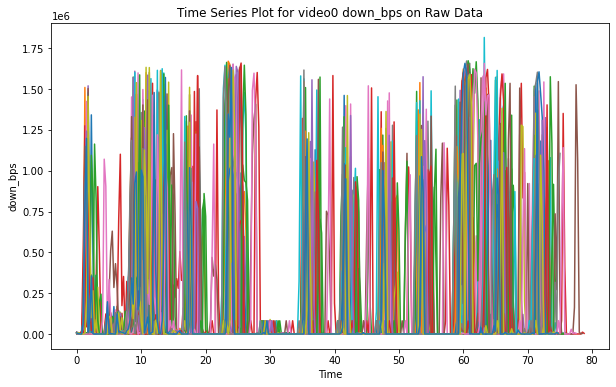

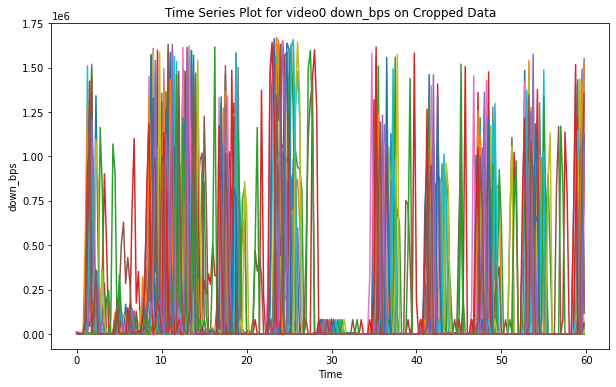

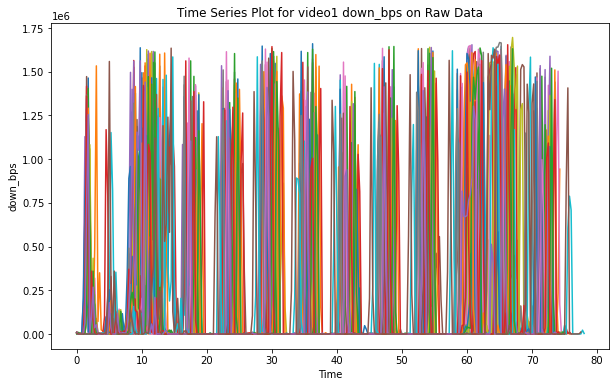

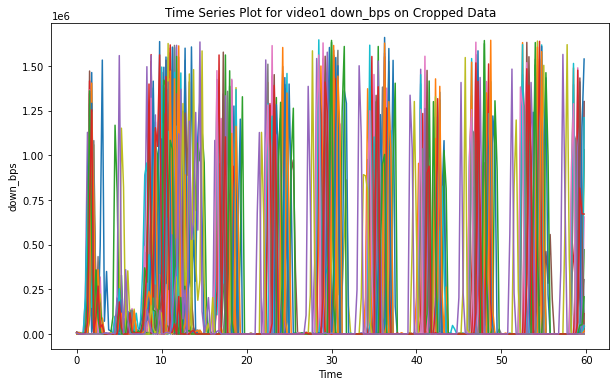

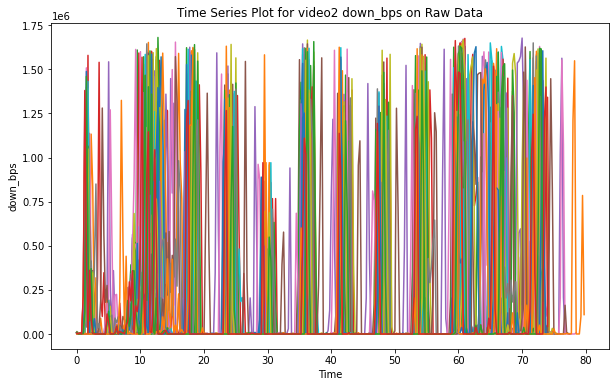

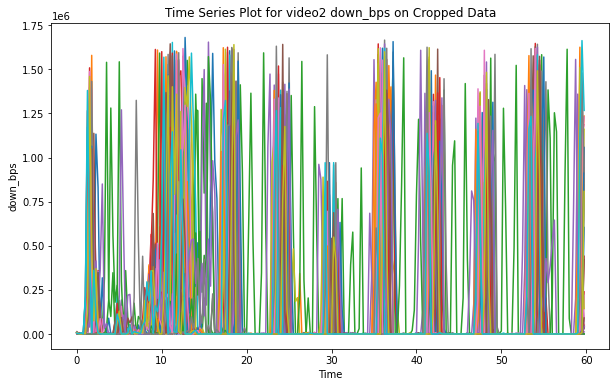

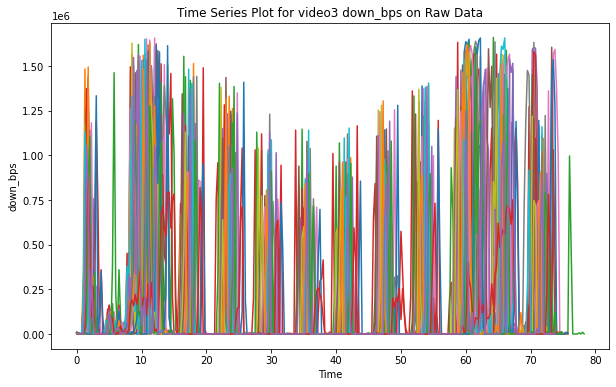

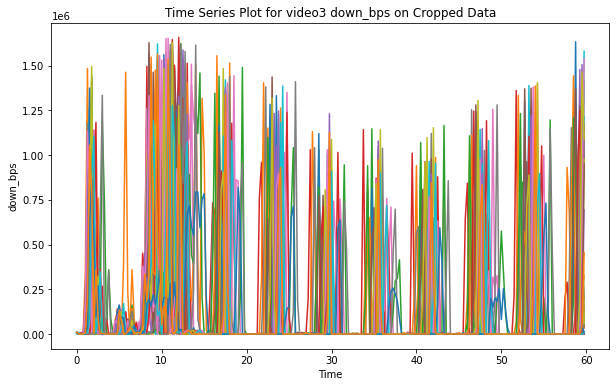

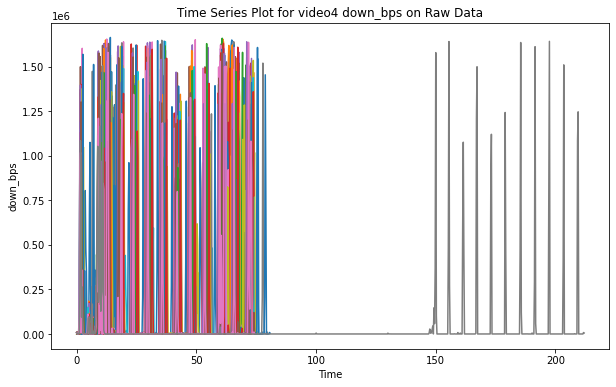

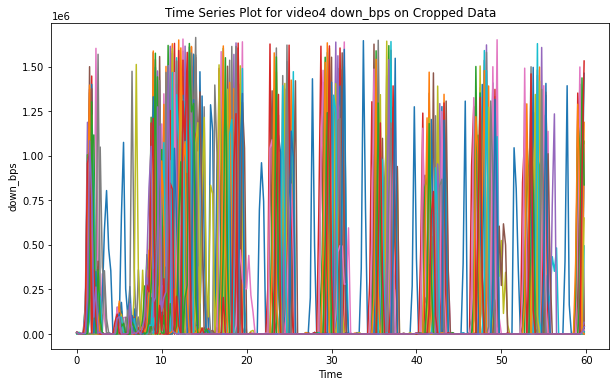

In [10]:
#View each video run layered ontop of each other (divided by video), before and after processing steps (Must Choose Column ex. 'down_bps')
plot_all_time_series_dfs(raw_one_node_dfs, raw_one_node_labels, one_node_dfs, one_node_labels ,'down_bps')

### Multi Node Video Streams pre/post processing, for down_bps

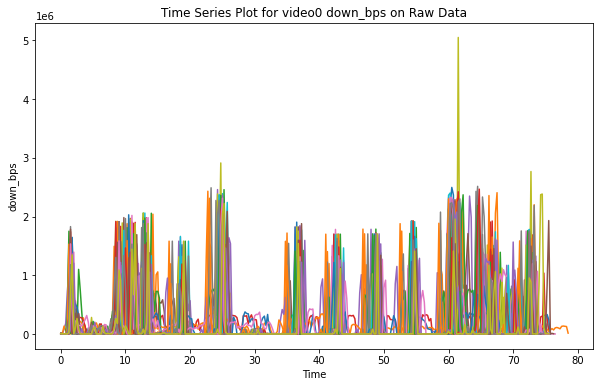

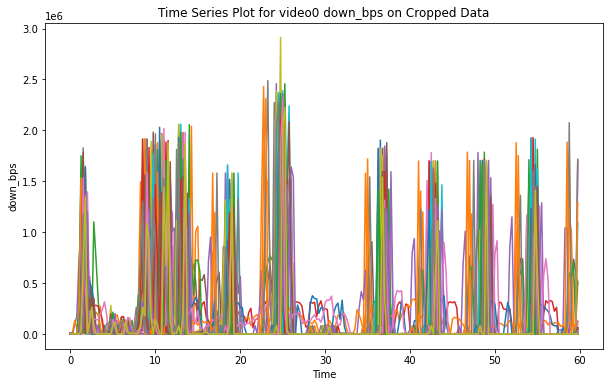

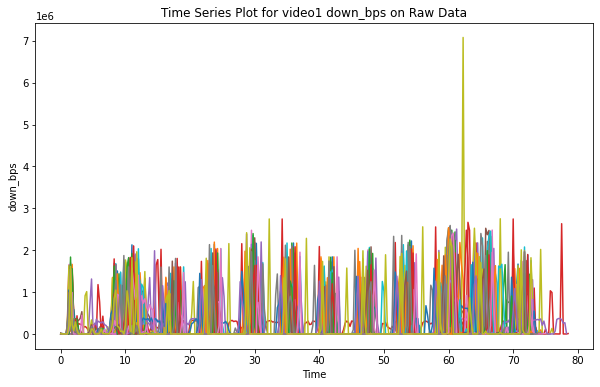

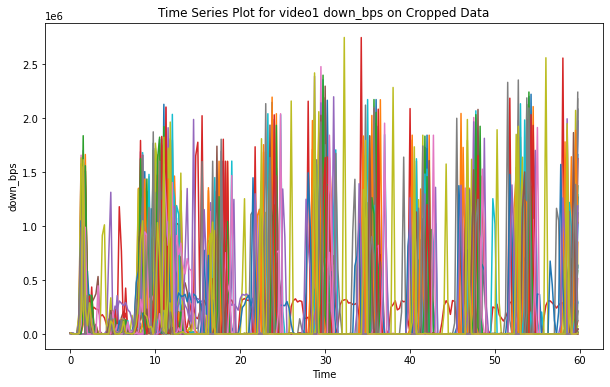

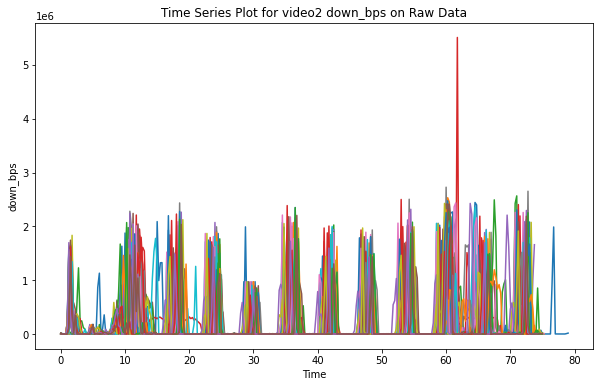

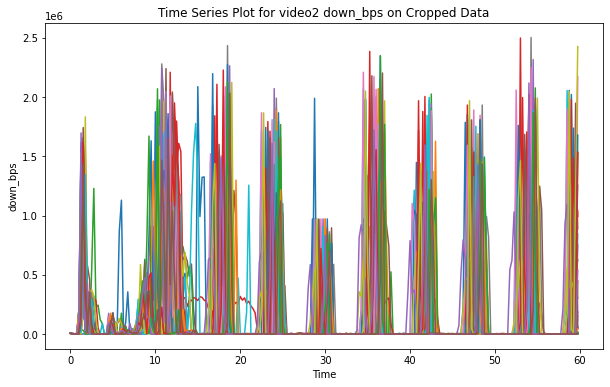

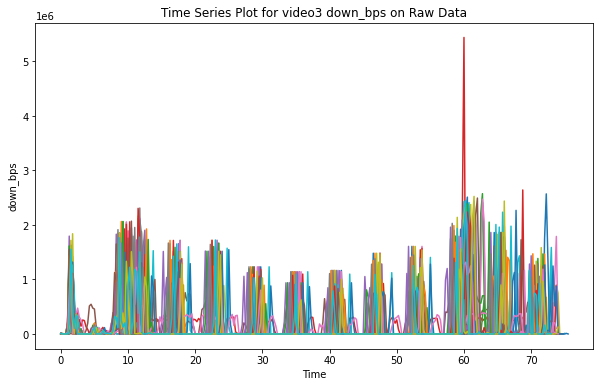

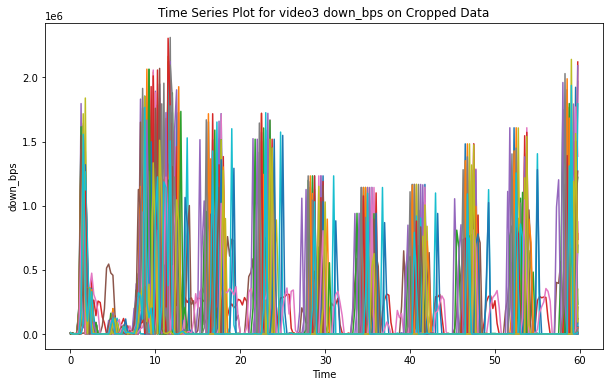

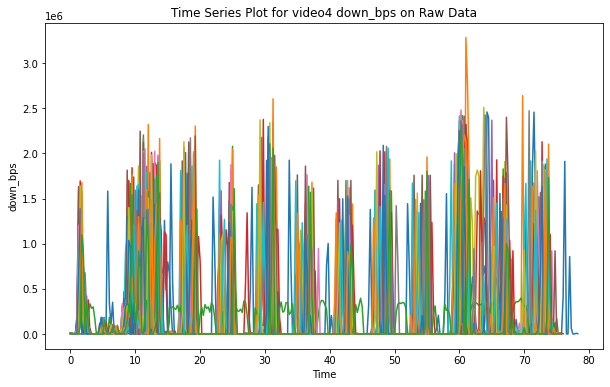

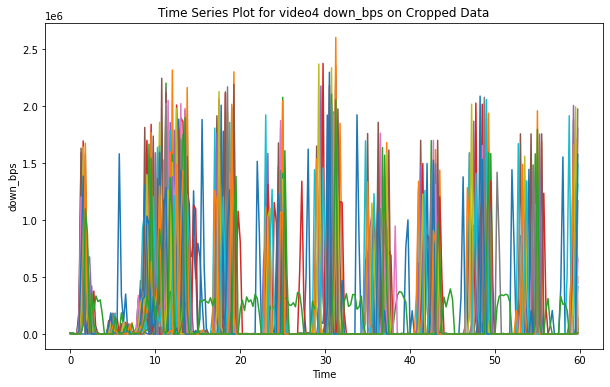

In [11]:
#View each video run layered ontop of each other (divided by video), before and after processing steps (Must Choose Column ex. 'down_bps')
plot_all_time_series_dfs(raw_multi_node_dfs,raw_multi_node_labels, multi_node_dfs, multi_node_labels ,'down_bps')

# Classifier Model Training

In [12]:
%pip install scikit-learn
%pip install tensorflow
%pip install trustee

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from trustee import ClassificationTrustee



Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pi

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-11 05:02:16.760814: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 05:02:16.764016: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 05:02:16.803825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 05:02:16.803842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register 

## Sklearn RandomForestClassifier

In [13]:
#Function to train a Random Forest Classifier on a Dataframe
#Has the option to print_report from sklearn, or print_trustee_report which is to print the trustee report 
def Random_Forest_Classifier(df,print_report=False, print_trustee_report=False):

    X = df.drop('video', axis=1)  # Features from DataFrame
    y = df['video']  # Labels from your existing array

    # Split the dataset into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Create and train the Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy or other performance metric
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    
    if print_report:
        print(classification_report(y_test, y_pred))
        
    if print_trustee_report:
        trustee = ClassificationTrustee(expert=clf)
        trustee.fit(X_train, y_train, num_samples=len(X_train) // 2, num_iter=20, train_size=0.99)

        # Display Trustee Results
        _, dt, _, score = trustee.explain()
        print(f"Training score of pruned DT: {score}")
        dt_y_pred = dt.predict(X_train)
        print("Model explanation global fidelity report:")
        print(metrics.classification_report(clf.predict(X_train), dt_y_pred))
        print("Model explanation score report:")
        print(metrics.classification_report(y_train, dt_y_pred))

        # plot a tree
        fig = plt.figure(figsize=(25,20))
        plot_tree(dt, feature_names=X_train.columns, class_names=sorted(df['video'].unique()), filled=True, max_depth=5)


    return accuracy

#Function That Will First Create and Train a Random Forest Classifier on the entire Concat Dataframe, then output a full report on the model statistics
#Then the function will evaluate each time frames accuracy and return the time dataframe corresponding to the highest accuracy
def Random_Forest_Classifier_With_Interval_Report(videos_concat):
    print("COMBINED TIME FRAME ACCURACY REPORT")

    # Print The Report for the Overall Concat Dataframe accuracy
    Random_Forest_Classifier(videos_concat, print_report=True)

    # Print all the interval accuracies in videos_concat
    best_accuracy = 0.0
    best_df = None
    best_time = None
    print("INDIVIDUAL TIME FRAME ACCURACY REPORT")
    unique_times = videos_concat.index.unique()
    for time in unique_times:
        df = videos_concat.loc[videos_concat.index == time].reset_index(drop=True)
        accuracy = Random_Forest_Classifier(df)
        print(f"Time: {time}, Accuracy: {accuracy:.4f}")  # Format for 4 decimal places
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_df = df
            best_time = time

    print()        
    print(f"Best Time: {best_time}, Best Accuracy: {best_accuracy:.4f}")  # Format for 4 decimal places
    
    return best_df



### One Node Random Forest Classifier Results

In [14]:
#TIME SAVER: Obtain dataframe from CSV so no need to preprocess data every use (Keep Commented Unless Used)
print("ONE NODE ACCURACY REPORTS")
one_node_csv_name = 'capture_8_5s_concat2.csv'       # (Pre-Made Capture: 1 node, 5 vidoes, 50 watcher per video, 60 seconds, 5 second interval)

#Obtain the concated dataframe for the entire packet capture
one_node_concat = pd.read_csv(f"{os.getenv('SNL_SERVER_PATH')}{one_node_csv_name}", index_col=0)

one_node_best_df = Random_Forest_Classifier_With_Interval_Report(one_node_concat)



ONE NODE ACCURACY REPORTS
COMBINED TIME FRAME ACCURACY REPORT
              precision    recall  f1-score   support

      video0       0.70      0.62      0.66       130
      video1       0.66      0.66      0.66       127
      video2       0.65      0.66      0.65       155
      video3       0.65      0.60      0.62       116
      video4       0.53      0.63      0.57       113

    accuracy                           0.63       641
   macro avg       0.64      0.63      0.63       641
weighted avg       0.64      0.63      0.64       641

INDIVIDUAL TIME FRAME ACCURACY REPORT
Time: 0, Accuracy: 0.2222
Time: 5, Accuracy: 0.3333
Time: 10, Accuracy: 0.4259
Time: 15, Accuracy: 0.8704
Time: 20, Accuracy: 0.7222
Time: 25, Accuracy: 0.5741
Time: 30, Accuracy: 0.6481
Time: 35, Accuracy: 0.9259
Time: 40, Accuracy: 0.9259
Time: 45, Accuracy: 0.9444
Time: 50, Accuracy: 0.8519
Time: 55, Accuracy: 0.5556

Best Time: 45, Best Accuracy: 0.9444


### Multi Node Random Forest Classifier Results

In [15]:
#TIME SAVER: Obtain dataframe from CSV so no need to preprocess data every use (Keep Commented Unless Used)

multi_node_csv_name = 'capture_4_5s_concat2.csv'       # (Pre-Made Capture: 50 nodes, 5 videos, 50 watches per video, 60 seconds, 5 second interval)

#Obtain the concated dataframe for the entire packet capture
multi_node_concat = pd.read_csv(f"{os.getenv('SNL_SERVER_PATH')}{multi_node_csv_name}", index_col=0)

multi_node_best_df = Random_Forest_Classifier_With_Interval_Report(multi_node_concat)

COMBINED TIME FRAME ACCURACY REPORT
              precision    recall  f1-score   support

      video0       0.68      0.78      0.72       174
      video1       0.72      0.62      0.67       173
      video2       0.65      0.74      0.69       153
      video3       0.72      0.73      0.73       162
      video4       0.62      0.48      0.54       120

    accuracy                           0.68       782
   macro avg       0.68      0.67      0.67       782
weighted avg       0.68      0.68      0.68       782

INDIVIDUAL TIME FRAME ACCURACY REPORT
Time: 0, Accuracy: 0.3485
Time: 5, Accuracy: 0.5303
Time: 10, Accuracy: 0.3333
Time: 15, Accuracy: 0.7727
Time: 20, Accuracy: 0.7121
Time: 25, Accuracy: 0.6212
Time: 30, Accuracy: 0.7273
Time: 35, Accuracy: 0.7879
Time: 40, Accuracy: 0.8788
Time: 45, Accuracy: 0.9091
Time: 50, Accuracy: 0.7727
Time: 55, Accuracy: 0.5758

Best Time: 45, Best Accuracy: 0.9091


## Trustee Model Evaluation RandomForestClassifier 

### One Node Trustee

Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

      video0       0.94      0.77      0.85        22
      video1       0.95      1.00      0.98        20
      video2       1.00      1.00      1.00        34
      video3       0.88      1.00      0.94        23
      video4       0.88      0.88      0.88        25

    accuracy                           0.94       124
   macro avg       0.93      0.93      0.93       124
weighted avg       0.94      0.94      0.93       124

Model explanation score report:
              precision    recall  f1-score   support

      video0       0.94      0.77      0.85        22
      video1       0.95      1.00      0.98        20
      video2       1.00      1.00      1.00        34
      video3       0.88      1.00      0.94        23
      video4       0.88      0.88      0.88        25

    accuracy                           0.94       124
   macro avg       0.93 

/home/dakotabarnes/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


0.9444

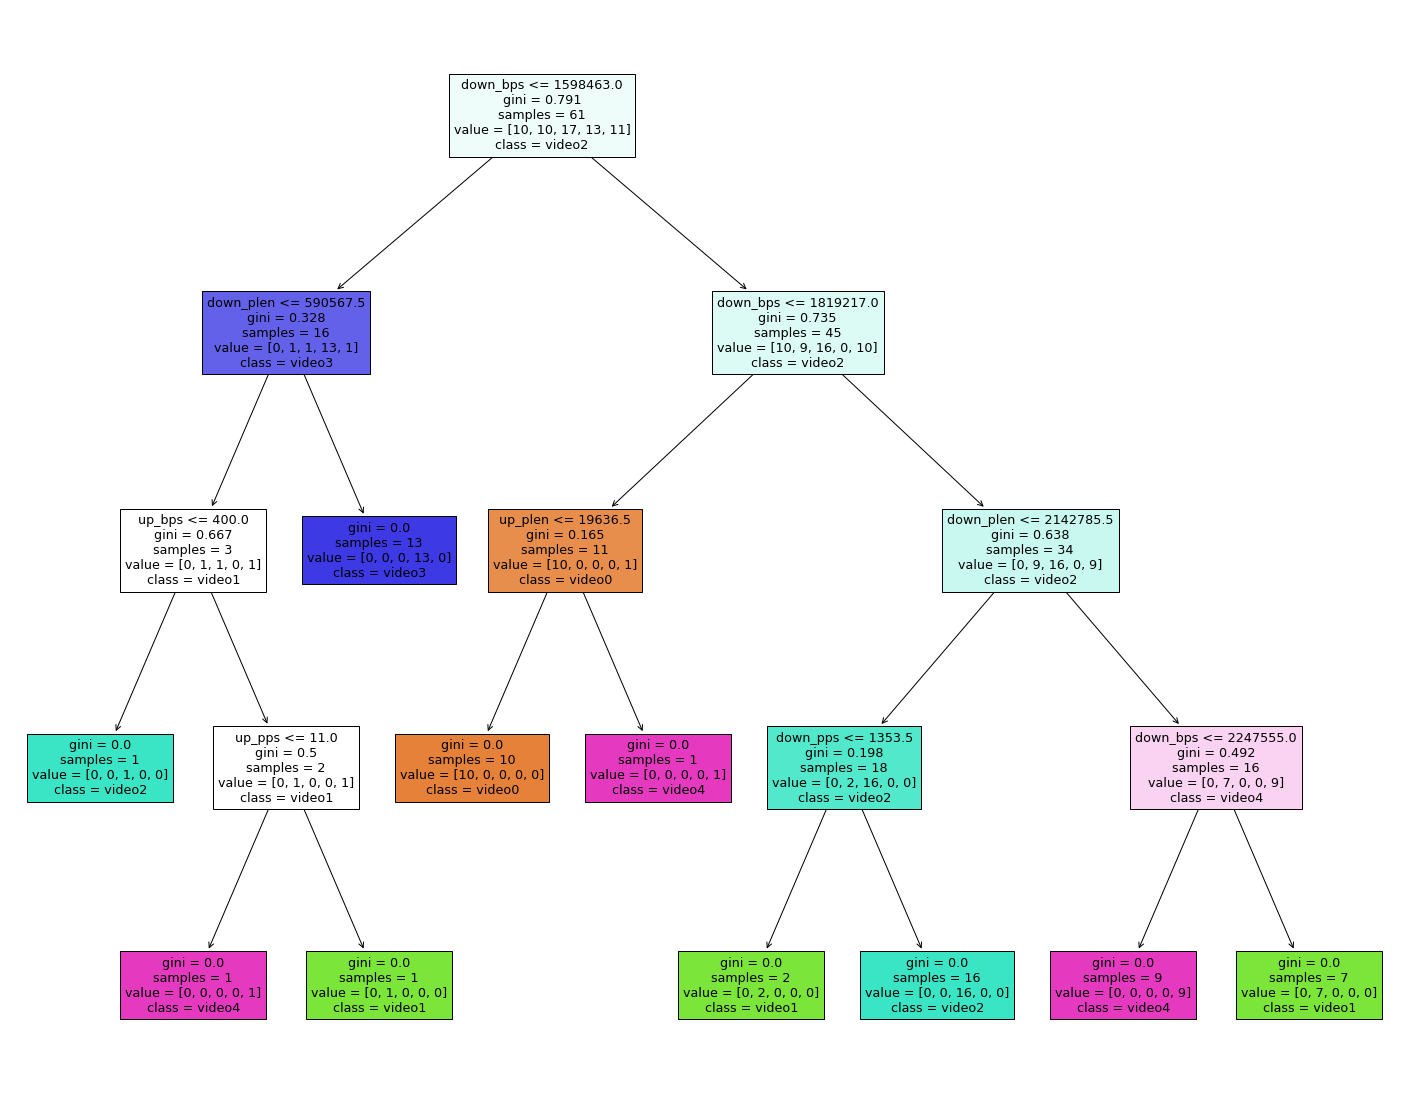

In [16]:
#Run the Trustee Visualization Report on the Best Preforming time frame to visualize the choices that are being made
Random_Forest_Classifier(one_node_best_df, print_trustee_report=True)

### Mutli Node Trustee

Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

      video0       0.89      0.86      0.88        37
      video1       1.00      0.85      0.92        34
      video2       0.97      1.00      0.98        31
      video3       0.90      1.00      0.95        28
      video4       0.83      0.90      0.86        21

    accuracy                           0.92       151
   macro avg       0.92      0.92      0.92       151
weighted avg       0.92      0.92      0.92       151

Model explanation score report:
              precision    recall  f1-score   support

      video0       0.89      0.86      0.88        37
      video1       1.00      0.85      0.92        34
      video2       0.97      1.00      0.98        31
      video3       0.90      1.00      0.95        28
      video4       0.83      0.90      0.86        21

    accuracy                           0.92       151
   macro avg       0.92 

/home/dakotabarnes/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


0.9091

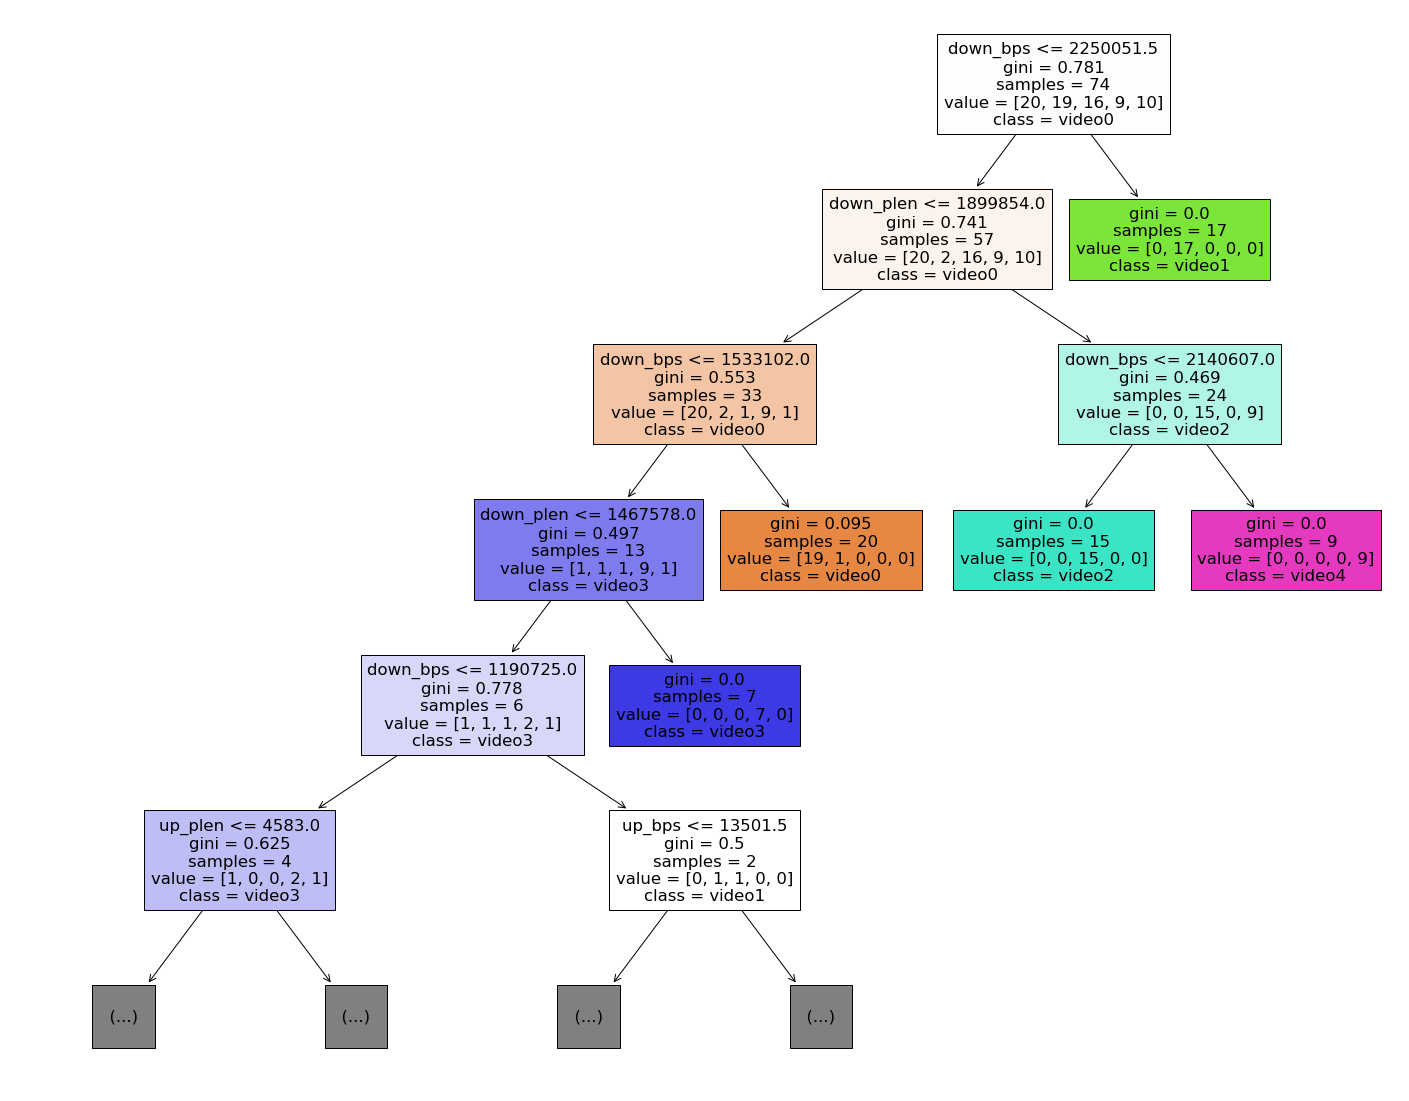

In [17]:
#Run the Trustee Visualization Report on the Best Preforming time frame to visualize the choices that are being made
Random_Forest_Classifier(multi_node_best_df, print_trustee_report=True)

## PyTorch Convolutional Neural Network
- Take in video_dfs which is a list of dataFrames, where each dataframe is one video
- Is able to view connections between timeframes, which the RandomForestClassifier can not do (3D vs 2D)

In [46]:
def Convolutional_Neural_Network(X, y):
    
    # Prepare the data
    # Reshape X for CNN input (samples, time segments, features, 1)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

    # Encode the labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=45)

    # Create the CNN model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=36)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy*100}%")
    

    

In [69]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

def Convolutional_Neural_Network(X, y):
    
    # Reshape X for CNN input
    X = X.reshape((X.shape[0], 240, 6, 1))

    # Encode the labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=45)

    # Create the CNN model
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(240, 6)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=30, batch_size=32)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy*100}%")
    
    
#function used to convert list of dataframes into np.array
def df_list_to_np_arrays(list_dfs):
    X_list = []
    y_list = []

    for df in list_dfs:
        # Reset the index to convert the 'time' index into a column
        df_reset = df.reset_index()
        # Assuming the label is in the last column
        X_list.append(df_reset.iloc[:, 1:-1].values)  # Excluding time column  
        y_list.append(df_reset.iloc[:, -1].values[0])  # Label (assuming all rows in a DF have the same label)

    # Convert lists to numpy arrays
    X = np.array(X_list)
    y = np.array(y_list)


    return X, y

### One Node Convolutional Neural Network

In [67]:
one_node_X, one_node_y = df_list_to_np_arrays(one_node_dfs)

#one_node_X = np.load(f"{os.getenv('SNL_SERVER_PATH')}capture_8_60_0.25_X.npy")
#one_node_y = np.load(f"{os.getenv('SNL_SERVER_PATH')}capture_8_60_0.25_y.npy")

#Columns to be removed Based on the RandomForestClassifier Interval Report
#rows_to_remove = [0, 5, 10]

# Iterate over each DataFrame and drop the specified columns
#for df in one_node_dfs:
#    df.drop(rows_to_remove, axis=0, inplace=True, errors='ignore')

#Run CNN on the list of dataframes
#one_node_dfs must be processed and kept on memory because 3D data
Convolutional_Neural_Network(one_node_X, one_node_y)

Epoch 1/30
5/5 [==============================] - 1s 20ms/step - loss: 3.8155 - accuracy: 0.2606
Epoch 2/30
5/5 [==============================] - 0s 22ms/step - loss: 1.8917 - accuracy: 0.4930
Epoch 3/30
5/5 [==============================] - 0s 24ms/step - loss: 0.8666 - accuracy: 0.6901
Epoch 4/30
5/5 [==============================] - 0s 22ms/step - loss: 0.6454 - accuracy: 0.7817
Epoch 5/30
5/5 [==============================] - 0s 22ms/step - loss: 0.3296 - accuracy: 0.9014
Epoch 6/30
5/5 [==============================] - 0s 22ms/step - loss: 0.3237 - accuracy: 0.8944
Epoch 7/30
5/5 [==============================] - 0s 23ms/step - loss: 0.2499 - accuracy: 0.9155
Epoch 8/30
5/5 [==============================] - 0s 23ms/step - loss: 0.1898 - accuracy: 0.9155
Epoch 9/30
5/5 [==============================] - 0s 23ms/step - loss: 0.2185 - accuracy: 0.9437
Epoch 10/30
5/5 [==============================] - 0s 22ms/step - loss: 0.1354 - accuracy: 0.9718
Epoch 11/30
5/5 [============

### Mutli Node Convolutional Neural Network

In [68]:
multi_node_X, multi_node_y = df_list_to_np_arrays(multi_node_dfs)

#multi_node_X = np.load(f"{os.getenv('SNL_SERVER_PATH')}capture_4_60_5_X.npy")
#multi_node_y = np.load(f"{os.getenv('SNL_SERVER_PATH')}capture_4_60_5_y.npy")

#Columns to be removed Based on the RandomForestClassifier Interval Report
#rows_to_remove = [0, 5, 10]

# Iterate over each DataFrame and drop the specified columns
#for df in multi_node_dfs:
#    df.drop(rows_to_remove, axis=0, inplace=True, errors='ignore')

#Run CNN on the list of dataframes
#one_node_dfs must be processed and kept on memory because 3D data
Convolutional_Neural_Network(multi_node_X, multi_node_y)

Epoch 1/30
6/6 [==============================] - 1s 22ms/step - loss: 3.2153 - accuracy: 0.3526
Epoch 2/30
6/6 [==============================] - 0s 22ms/step - loss: 1.3054 - accuracy: 0.6936
Epoch 3/30
6/6 [==============================] - 0s 23ms/step - loss: 0.5594 - accuracy: 0.8150
Epoch 4/30
6/6 [==============================] - 0s 22ms/step - loss: 0.2719 - accuracy: 0.8902
Epoch 5/30
6/6 [==============================] - 0s 23ms/step - loss: 0.2486 - accuracy: 0.8960
Epoch 6/30
6/6 [==============================] - 0s 22ms/step - loss: 0.1827 - accuracy: 0.9595
Epoch 7/30
6/6 [==============================] - 0s 22ms/step - loss: 0.2194 - accuracy: 0.9306
Epoch 8/30
6/6 [==============================] - 0s 22ms/step - loss: 0.0689 - accuracy: 0.9827
Epoch 9/30
6/6 [==============================] - 0s 22ms/step - loss: 0.1368 - accuracy: 0.9364
Epoch 10/30
6/6 [==============================] - 0s 22ms/step - loss: 0.1862 - accuracy: 0.9480
Epoch 11/30
6/6 [============

In [52]:
###### BEEEEEEEEEEP (To know when finished)

from IPython.display import Audio, display

def play_beep():
    framerate = 44100
    duration = 1  # in seconds
    frequency = 500  # Hz, standard A4 tone

    t = np.linspace(0, duration, int(framerate * duration))
    audio_data = np.sin(2 * np.pi * frequency * t)

    display(Audio(audio_data, rate=framerate, autoplay=True))

# Play beep when the code finishes
play_beep()
